In [1]:
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import math
from keras.models import Sequential, Model
from keras.layers import Input, Activation, GRU, Dense, LSTM, RepeatVector
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, normalize
import holidays

Using TensorFlow backend.


In [2]:
# !pip install fbprophet
# !pip install sklearn

In [3]:
content_type = 1000
df = pd.read_csv('train/train_1.csv',nrows=content_type) # 100 Content Type
df = df.fillna(0)
arr = df.values[:,1:]
start_date = df.columns[1].split('-')
start_date_weekday = datetime.datetime(int(start_date[0]),int(start_date[1]),int(start_date[2]))
weekday = start_date_weekday.weekday()
weekday_data = np.arange(weekday,len(df.columns)+weekday,1)
f = lambda x: x%7
weekday_data = f(weekday_data)


[2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3
 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5
 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0
 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2
 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4
 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6
 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1
 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3
 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5
 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0
 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2
 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4
 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6
 0 1 2 3 4 5 6 0 1 2 3 4 

In [4]:
holiday = holidays.CA() + holidays.US() + holidays.IND()
holiday_data = []
for day in df.columns[1:]:
    holiday_data.append(int(day in holiday))
    
print(holiday_data.count(1))

33


In [5]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### GRU + features

- 1 day + EMA 

In [8]:
num_hidden_units = 64
num_outputs = 1
windows = [1]
exp_avg = None
sim_avg = None
alpha = 0.1

148066.98954223035


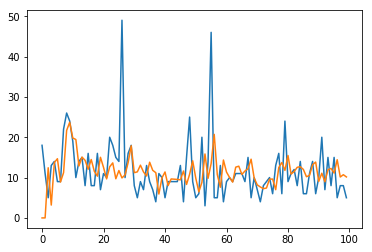

In [9]:
for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None or sim_avg is None:
            exp_avg = arr[:, i-1]
            sim_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
            sim_avg = (sim_avg*i-1 + arr[:, i-1])/i
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1)), axis=1).astype(float)).reshape(-1, 1, 2)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

- 1 day + EMA + weekday

146556.14747319836


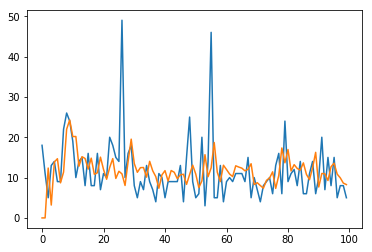

In [11]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1),weekday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1)), axis=1).astype(float)).reshape(-1, 1, 3)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
#         week += 1
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

1 day+ EMA + weekday + holiday

145330.74507006


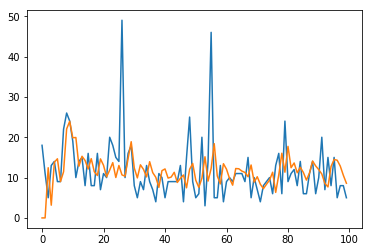

In [37]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1),
                                  weekday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1),
                                 holiday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1)
                                 ), axis=1).astype(float)).reshape(-1, 1, 4)
#         print(i,arr[:, i-1 : i])
#         print(holiday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1))
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

- 1 day + 7 day + 14 day + EMA 

In [ ]:
exp_avg = None
windows = [1,7,14]

for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1)), axis=1).astype(float)).reshape(-1, 1, 2)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

In [ ]:
weekday_data[1]*np.ones(arr.shape[0],dtype=int)
print(weekday_data.shape)

Autoencoder

In [ ]:
timesteps = 1
sample_size = arr.shape[1]
input_dim = arr.shape[0]

encoder_inputs = arr.reshape(sample_size ,timesteps,input_dim)

In [ ]:

def get_model(n_dimensions):
    inputs = Input(shape=(1, input_dim))
    encoded = LSTM(n_dimensions, return_sequences=False, name="encoder")(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True, name='decoder')(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    return autoencoder, encoder


autoencoder, encoder = get_model(5)
autoencoder.compile(optimizer='adam', loss='mse', 
                    metrics=['acc', 'cosine_proximity'])

history = autoencoder.fit(encoder_inputs, encoder_inputs, epochs=100)
decoded = autoencoder.predict(encoder_inputs)
encoded = encoder.predict(encoder_inputs)

In [ ]:
# print(encoded)
print(encoded.shape)
print(decoded.shape)
# print(en)
decoded = np.array(decoded,dtype=int)
print(decoded)

In [ ]:
shaped = arr.reshape(1000,1,550)
print(shaped.shape)
# print(shaped)

Simple AE at 0.8 dimension

In [26]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    encoding_dim = int(arr.shape[0]*0.8)
    input_shape = Input(shape=(content_type,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_shape)
    decoded = Dense(content_type, activation='relu')(encoded)
    encoder = Model(input_shape, encoded)
    autoencoder = Model(input_shape, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mse')

    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        X = arr[:,i].reshape(1,content_type)
#         print(X.shape)
        p = autoencoder.predict(X)
#         print(p)
        preds[:, i] = p.reshape(content_type)
        autoencoder.fit(X, X, epochs=200, verbose=0)
        req_sum[i] = np.sum(X)
        pred_req_sum[i] = np.sum(p,dtype=int)
                            
                    

172829.4983207035


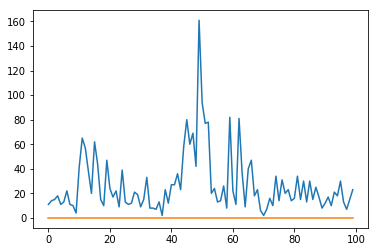

In [29]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[1][:100])
plt.plot(preds[1][:100])
plt.show()

mean:  29632.32181818182 | pred_mean:  10040.918181818182
var:  260362708.45097852 | pred_var:  6684107.286033059
correlation:
 actual vs predicted 
 [[1.         0.55560321]
 [0.55560321 1.        ]]


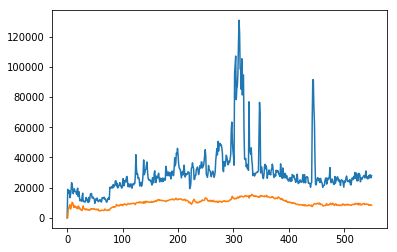

In [30]:
print("mean: ",np.mean(req_sum),"| pred_mean: ", np.mean(pred_req_sum))
print("var: ",np.var(req_sum),"| pred_var: ", np.var(pred_req_sum))
print("correlation:\n actual vs predicted \n", np.corrcoef(req_sum,pred_req_sum))

plt.plot(range(len(req_sum)),req_sum)
plt.plot(range(len(pred_req_sum)),pred_req_sum)

In [ ]:
preds[:][5]

Simple AE with 0.2 dimension

In [19]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    encoding_dim = int(arr.shape[0]*0.2)
    input_shape = Input(shape=(content_type,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_shape)
    decoded = Dense(content_type, activation='relu')(encoded)
    encoder = Model(input_shape, encoded)
    autoencoder = Model(input_shape, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mse')

    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        X = arr[:,i].reshape(1,content_type)
#         print(X.shape)
        p = autoencoder.predict(X)
#         print(p)
        preds[:, i] = p.reshape(content_type)
        autoencoder.fit(X, X, epochs=200, verbose=0)
        req_sum[i] = np.sum(X)
        pred_req_sum[i] = np.sum(p,dtype=int)

239795.2715765847


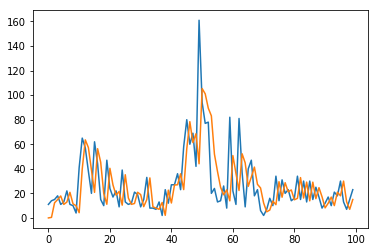

In [20]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[1][:100])
plt.plot(preds[1][:100])
plt.show()

mean:  29632.32181818182 | pred_mean:  10884.192727272728
var:  260362708.45097852 | pred_var:  9693400.3628562
correlation: [[1.        0.5093163]
 [0.5093163 1.       ]]


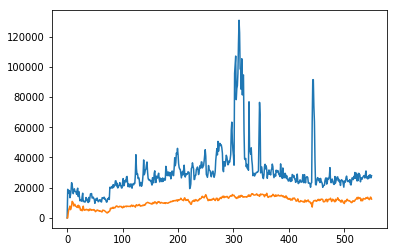

In [21]:
print("mean: ",np.mean(req_sum),"| pred_mean: ", np.mean(pred_req_sum))
print("var: ",np.var(req_sum),"| pred_var: ", np.var(pred_req_sum))
print("correlation:", np.corrcoef(req_sum,pred_req_sum))

plt.plot(range(len(req_sum)),req_sum)
plt.plot(range(len(pred_req_sum)),pred_req_sum)

Simple AE , scaled inputs , 0.8

In [34]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    encoding_dim = int(arr.shape[0]*0.8)
    input_shape = Input(shape=(content_type,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_shape)
    decoded = Dense(content_type, activation='relu')(encoded)
    encoder = Model(input_shape, encoded)
    autoencoder = Model(input_shape, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mse')

    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        X = scale(arr[:,i].reshape(1,content_type).astype(float))
#         print(X.shape)
        p = autoencoder.predict(X)
#         print(p)
        preds[:, i] = p.reshape(content_type)
        autoencoder.fit(X, X, epochs=200, verbose=0)
        req_sum[i] = np.sum(X)
        pred_req_sum[i] = np.sum(p,dtype=int)


256795.3546151007


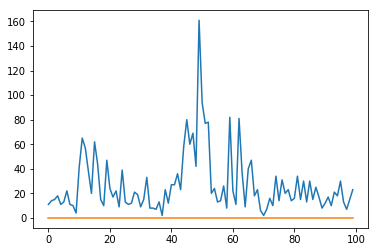

In [35]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[1][:100])
plt.plot(preds[1][:100])
plt.show()